In [1]:
# Standard libraries
from PIL import Image
from pathlib import Path
from IPython.display import SVG, display

# Repo files
from train import basic_transforms, mean, std
from src.ShapeRenderer import ShapeRenderer
from src.ShapeRendererSVG import ShapeRendererSVG
from src.utils import unnormalize_functional, rgba_to_rgb, unnormalize_to
from src.models import Model

# Torch imports
import torch
import torchvision.transforms.functional as TF

# Additional libraries
from tqdm.notebook import tqdm

C:\Users\Simon\Anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
n_shapes = 16
image_size = 64
svg_image_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(n_shapes=n_shapes).to(device)
renderer = ShapeRenderer(device=device, imsize=image_size, minimum_sharpness=10).to(device)
svg_renderer = ShapeRendererSVG(internal_renderer=renderer, canvas_size=svg_image_size, mean=mean, std=std)

model.load_state_dict(torch.load(r".\checkpoints\celeba.pt")['G'])
model.to(device)
model.eval()
pass

'Input image'

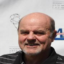

'Fuzzy training output'

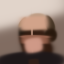

'Crisp evaluation output'

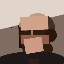

In [3]:
# Load image and view it
input_image = Image.open(r"C:\projects\data\celeba_val\main\008189.jpg")
input_tensor = basic_transforms(input_image).to(device)
display("Input image", TF.to_pil_image(unnormalize_functional(input_tensor, mean, std)))

# Forward image through net and renderer
shape_args = model(input_tensor.unsqueeze(0))
renderer.train()
output_image = rgba_to_rgb(renderer(shape_args).squeeze(0))
display("Fuzzy training output", TF.to_pil_image(unnormalize_functional(output_image, mean, std)))

# Render using sharp images
renderer.eval()
output_image = rgba_to_rgb(renderer(shape_args).squeeze(0))
display("Crisp evaluation output", TF.to_pil_image(unnormalize_functional(output_image, mean, std)))

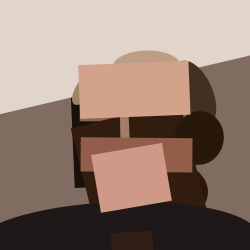

In [4]:
svg_string = svg_renderer.get_string(shape_args.squeeze(0))
display(SVG(svg_string))

In [5]:
input_path = Path(r"...somepath...")
canvas_size = 200
output_path = Path("...sometotherpath...") / (input_path.parent.name + "_pred")
output_path.mkdir(exist_ok=True, parents=True)

files = list(input_path.iterdir())
model.eval()
renderer.eval()


for file in tqdm(files):
    # I/O paths
    png_path = output_path / (file.stem + ".png")

    # Prepare image
    input_image = Image.open(file).convert("RGB")
    input_tensor = basic_transforms(input_image).to(device)

    # Run image through model
    shape_args = model(input_tensor.unsqueeze(0)).squeeze(0)
    svg_renderer.save_png(shape_args, png_path)

  0%|          | 0/10 [00:00<?, ?it/s]